In [1]:
import warnings

warnings.filterwarnings('ignore')

In [2]:
import os
import random
from statistics import mode

import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (ConfusionMatrixDisplay, classification_report,
                             confusion_matrix, f1_score, precision_score,
                             recall_score)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [3]:
RANDOM_SEED=42
random.seed(RANDOM_SEED)
os.environ["PYTHONHASHSEED"] = str(RANDOM_SEED)

## Датасет

In [4]:
df = pd.read_csv('../data/Skyserver_SQL2_27_2018 6_51_39 PM.csv')

Удаляем неинформативные колонки

In [5]:
df.drop(columns=['objid', 'run', 'rerun', 'camcol', 'field', 'specobjid', 'fiberid', 'plate', 'mjd'], inplace=True)

In [6]:
df.head()

,ra,dec,u,g,r,i,z,class,redshift
0,183.531326,0.089693,19.47406,17.04240,15.94699,15.50342,15.22531,STAR,-0.000009
1,183.598370,0.135285,18.66280,17.21449,16.67637,16.48922,16.39150,STAR,-0.000055
2,183.680207,0.126185,19.38298,18.19169,17.47428,17.08732,16.80125,GALAXY,0.123111
3,183.870529,0.049911,17.76536,16.60272,16.16116,15.98233,15.90438,STAR,-0.000111
4,183.883288,0.102557,17.55025,16.26342,16.43869,16.55492,16.61326,STAR,0.000590


## Обучение

У нас задача - предсказать класс, поэтому разобьем датасет на фичи и целевую метку

In [7]:
X = df.drop(columns=['class'])
y = df['class']

Разобьем данные на train и test подвыборки

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Константное предсказание

Замерим качество константного предсказания. Для всех метрик будем использовать взвешенное усреднение, потому что класс несбалансирован

In [9]:
def calculate_metrics(y_true, y_pred):
    print(f"Precision: {precision_score(y_test, y_pred, average='weighted')}")
    print(f"Recall: {recall_score(y_test, y_pred, average='weighted')}")
    print(f"F1: {f1_score(y_test, y_pred, average='weighted')}")

Для константных предсказаний возьмем самый частотный класс

In [10]:
dist_mode = mode(y_test)
y_pred = [dist_mode for _ in range(len(y_test))]
print("Метрики константного предсказания:")
calculate_metrics(y_test, y_pred)

Метрики константного предсказания:
Precision: 0.24900100000000003
Recall: 0.499
F1: 0.33222281521014


### Обучение модели классификации

Перед обучением надо предварительно конвертировать целевую метку в формат, удобный для модели. Выберем LabelEncoder, потому что у нас только одна категориальная переменная, и тут на самом деле без особой разницы, как именно ее кодировать. Если бы у нас было их несколько, то можно было бы использовать OneHotEncoder, чтобы модель не подумала, что между данными после препроцессинга есть какая-то связь

In [12]:
enc = LabelEncoder()
y_train = enc.fit_transform(y_train)
y_test = enc.fit_transform(y_test)

Для стандартизации используем StandartScaler. Мы видели, что данные неравномерно распределены в EDA и есть выбросы, поэтому это здесь нужно

In [14]:
scaler = StandardScaler()

X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

Обучаем непосредственно модель классификации. Для модели классификации мы выбрали DecisionTreeClassifier, потому что мне показалось, что задание предполагает взять какую-то легкую модель, если в 3 домашнем задании есть условие взять более умную модель.

In [15]:
cls = DecisionTreeClassifier()

In [16]:
cls.fit(X_train_scaled, y_train)

DecisionTreeClassifier()

## Метрики

In [17]:
y_pred = cls.predict(X_test_scaled)

In [18]:
print("Метрики модели LinearRegression")
calculate_metrics(y_test, y_pred)

Метрики модели LinearRegression
Precision: 0.9869504884205236
Recall: 0.987
F1: 0.9869600933259217


Построим дополнительно еще confusion matrix и выведем classification report для более полного понимания качества обучения модели

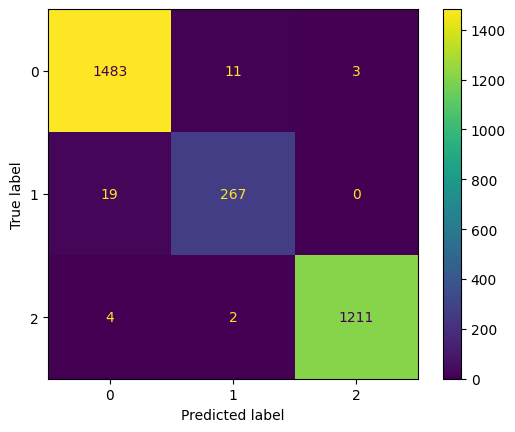

In [21]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

По confusion matrix  можно увидеть, что модель ошибается очень редко, что подтверждают метрики

In [22]:
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

        STAR       0.98      0.99      0.99      1497
      GALAXY       0.95      0.93      0.94       286
         QSO       1.00      1.00      1.00      1217

    accuracy                           0.99      3000
   macro avg       0.98      0.97      0.98      3000
weighted avg       0.99      0.99      0.99      3000



## Вывод

Была получена модель классификации звезд, галактик и квазаров со следующими метриками:
 - F1: 0.33 -> 0.99
 - Precision: 0.25 -> 0.99
 - Recall: 0.5 -> 0.99